# Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import pandas as pd

os.chdir(r"/content/gdrive/MyDrive/Я-профи подготовка по машинному обучению/Гринатом")
print(os.getcwd())

url = os.getcwd()
files = os.listdir(url)
files

/content/gdrive/MyDrive/Я-профи подготовка по машинному обучению/Гринатом


['imdb.vocab',
 'IMBD_Train.csv',
 'IMBD_Test.csv',
 'special_tokens_map.json',
 'tokenizer_config.json',
 'vocab.txt',
 'bert_classifier_imdb.pth',
 'wandb',
 'model_bert-base-uncased.pt']

In [ ]:
test = pd.read_csv('IMBD_Test.csv')
df = pd.read_csv('IMBD_Train.csv')

In [ ]:
!pip install wandb
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.5 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=451f41c349d1e84e9aa103cdad8f630caafd17e947afac5a024e452e411c6c39
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.9 MB/s eta 0:00:00


In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from tqdm import tqdm

# EDA

In [ ]:
df.head()

Unnamed: 0                                               Text  Sentiment  \
0           0  Zero Day leads you to think, even re-think why...          1   
1           1  Words can't describe how bad this movie is. I ...          0   
2           2  Everyone plays their part pretty well in this ...          1   
3           3  There are a lot of highly talented filmmakers/...          0   
4           4  I've just had the evidence that confirmed my s...          0   

   rate  
0    10  
1     1  
2    10  
3     1  
4     2

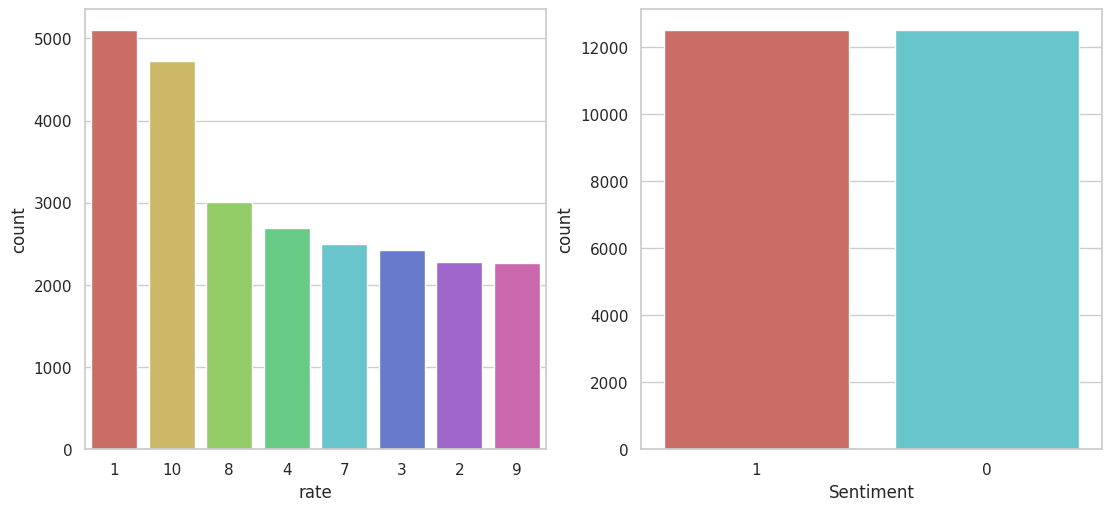

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

fig, ax = plt.subplots(1,2, figsize=(11, 5), constrained_layout = True)

sns.countplot(data=df, x='rate', ax=ax[0], order=df['rate'].value_counts().index, palette='hls')
sns.countplot(data=df, x='Sentiment', ax=ax[1], order=df['Sentiment'].value_counts().index, palette='hls')

fig.show()

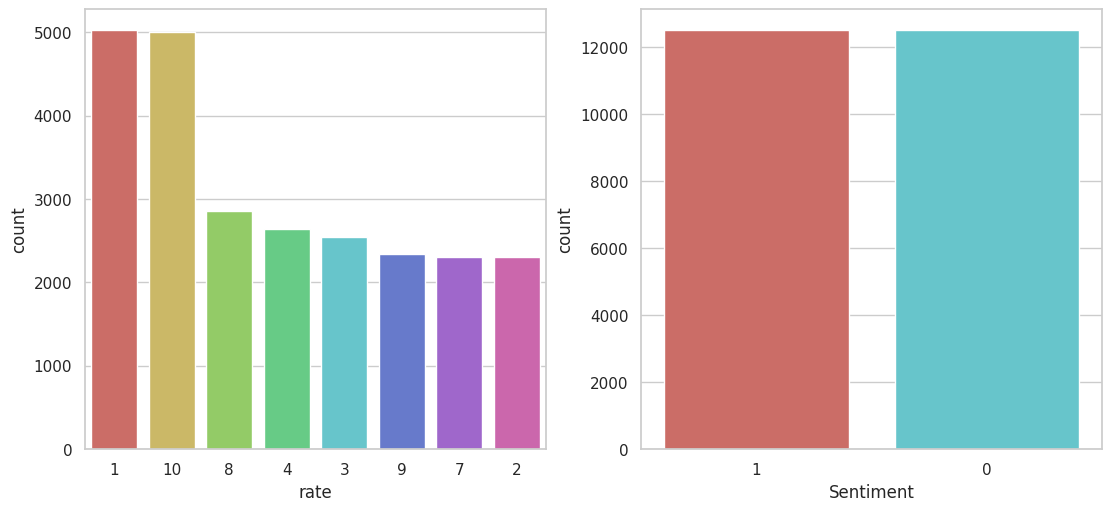

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

fig, ax = plt.subplots(1,2, figsize=(11, 5), constrained_layout = True)

sns.countplot(data=test, x='rate', ax=ax[0], order=test['rate'].value_counts().index, palette='hls')
sns.countplot(data=test, x='Sentiment', ax=ax[1], order=test['Sentiment'].value_counts().index, palette='hls')

fig.show()

# Attempt 1. Bert

Подробнее про сам Bert:

https://neurohive.io/ru/tutorial/bert-klassifikacya-teksta/

## Creat and train model

In [ ]:
import wandb

In [ ]:
# это только если используете wandb
# https://wandb.ai/
# если нет, то не надо
def wandb_log(**kwargs):
    """
    Logs a key-value pair to W&B
    """
    for k, v in kwargs.items():
        wandb.log({k: v})

In [ ]:
# это только если используете wandb
# https://wandb.ai/
# если нет, то не надо
# Log in to your W&B account
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
conf = dict(
    FEATURE_EXTRACTOR = 'bert-base-uncased',
    NUM_CLASSES = 2,
    MAX_LENGHT = 128,
    BS = 16,
    EPOCHS = 4,
    LR = 2e-5,
    MODEL_PATH='/content/gdrive/MyDrive/Я-профи подготовка по машинному обучению/Гринатом/bert_model_sentiment_clf.pt'
    )

run = wandb.init(
    project='bert_reviews',
    config=conf,
    job_type='train',
)

wandb: Currently logged in as: adela-x. Use `wandb login --relogin` to force relogin


In [ ]:
df

Unnamed: 0                                               Text  \
0               0  Zero Day leads you to think, even re-think why...   
1               1  Words can't describe how bad this movie is. I ...   
2               2  Everyone plays their part pretty well in this ...   
3               3  There are a lot of highly talented filmmakers/...   
4               4  I've just had the evidence that confirmed my s...   
...           ...                                                ...   
24995       24995  089: Footlight Parade (1933) - released 9/30/1...   
24996       24996  Deeply humorous yet honest comedy about a bunc...   
24997       24997  1st watched 2/28/2006 - 4 out of 10(Dir-Sydney...   
24998       24998  I watch lots of scary movies (or at least they...   
24999       24999  Absolutely the worst film yet by Burton, who s...   

       Sentiment  rate  
0              1    10  
1              0     1  
2              1    10  
3              0     1  
4              0     2  
...          ...   ...  
24995          1     8  
24996          1     9  
24997          0     4  
24998          0     2  
24999          0     2  

[25000 rows x 4 columns]

In [ ]:
# Класс создания датасета
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

# класс модели
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output
            x = self.dropout(pooled_output)
            logits = self.fc(x)
            return logits

# функция тренировки модели
def train_one_epoch(model, data_loader, optimizer, scheduler, device, log_wandb=True, verbose=False):
    model.train()
    running_loss = 0
    prog_bar = tqdm(enumerate(data_loader), total=len(data_loader))

    for batch in prog_bar:
        optimizer.zero_grad()
        input_ids = batch[1]['input_ids'].to(device)
        attention_mask = batch[1]['attention_mask'].to(device)
        labels = batch[1]['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        loss_item = loss.item()
        running_loss += loss_item

        prog_bar.set_description(f"loss: {loss_item:.4f}")

        if log_wandb == True:
            wandb_log(
                batch_train_loss=loss_item
            )

        if verbose == True and batch % 20 == 0:
            print(f"Batch: {batch}, Loss: {loss_item}")

    avg_loss = running_loss / len(train_dataloader)

    return avg_loss

@torch.no_grad()
def valid_one_epoch(model, valid_dataloader, epoch, device, log_wandb=True, verbose=False):
    """
    Validates the model for one epoch
    """
    model.eval()
    running_loss = 0
    prog_bar = tqdm(enumerate(valid_dataloader), total=len(valid_dataloader))
    for batch in prog_bar:
        input_ids = batch[1]['input_ids'].to(device)
        attention_mask = batch[1]['attention_mask'].to(device)
        labels = batch[1]['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        loss_item = loss.item()
        running_loss += loss_item

        prog_bar.set_description(f"val_loss: {loss_item:.4f}")

        if log_wandb == True:
            wandb_log(
                batch_val_loss=loss_item
            )

        if verbose == True and batch % 10 == 0:
            print(f"Batch: {batch}, Loss: {loss_item}")

    avg_val_loss = running_loss / len(valid_dataloader)

    return avg_val_loss

# функция оценки модели
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

# функция предсказания
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    # model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

    return "positive" if preds.item() == 1 else "negative"

In [ ]:
# зададим параметры для обучения модели на sentiment
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 128
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

texts = df['Text'].values
labels = df['Sentiment'].values
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

tokenizer = BertTokenizer.from_pretrained(bert_model_name)

train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bert = BERTClassifier(bert_model_name, conf['NUM_CLASSES']).to(device)

In [ ]:
optimizer = AdamW(model_bert.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
current_loss = 1000
log_wandb = True

for epoch in range(conf['EPOCHS']):
    print(f"\n{'--'*8} EPOCH: {epoch+1} {'--'*8}\n")
    train_loss = train_one_epoch(model_bert, train_dataloader, optimizer, scheduler, device, log_wandb=log_wandb)
    valid_loss = valid_one_epoch(model_bert, val_dataloader, epoch=epoch, device=device, log_wandb=log_wandb)
    accuracy, report = evaluate(model_bert, val_dataloader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)
    print(f"val_loss: {train_loss:.4f}")

    if log_wandb == True:
        wandb_log(
                train_loss=train_loss,
                valid_loss=valid_loss
        )

    if valid_loss < current_loss:
        current_loss = valid_loss
        torch.save(model_bert.state_dict(), f"model_{conf['FEATURE_EXTRACTOR']}.pt")



---------------- EPOCH: 1 ----------------



val_loss: 0.0879: 100%|██████████| 313/313 [01:44<00:00,  3.00it/s]


Validation Accuracy: 0.8910
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      2482
           1       0.87      0.91      0.89      2518

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000

val_loss: 0.2332

---------------- EPOCH: 2 ----------------



val_loss: 0.0347: 100%|██████████| 313/313 [01:45<00:00,  2.96it/s]


Validation Accuracy: 0.8868
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      2482
           1       0.88      0.90      0.89      2518

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000

val_loss: 0.1139

---------------- EPOCH: 3 ----------------



val_loss: 0.1091: 100%|██████████| 313/313 [01:46<00:00,  2.94it/s]


Validation Accuracy: 0.8858
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      2482
           1       0.89      0.88      0.89      2518

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000

val_loss: 0.0460

---------------- EPOCH: 4 ----------------



val_loss: 0.1414: 100%|██████████| 313/313 [01:44<00:00,  2.98it/s]


Validation Accuracy: 0.8858
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      2482
           1       0.88      0.89      0.89      2518

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000

val_loss: 0.0240


In [ ]:
torch.save(model_bert.state_dict(), "bert_classifier_imdb.pth")

## Test model on test dataset

In [ ]:
test.head()

Unnamed: 0                                               Text  Sentiment  \
0           0  Don't hate Heather Graham because she's beauti...          1   
1           1  I don't know how this movie has received so ma...          0   
2           2  I caught this movie on the Horror Channel and ...          1   
3           3  NBC had a chance to make a powerful religious ...          0   
4           4  Looking for something shocking? Okay fine... t...          0   

   rate  
0     9  
1     1  
2     8  
3     1  
4     1

In [ ]:
# зададим параметры для обучения модели
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 128
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

texts_test = test['Text'].values
labels_test = test['Sentiment'].values

tokenizer = BertTokenizer.from_pretrained(bert_model_name)

test_dataset = TextClassificationDataset(texts_test, labels_test, tokenizer, max_length)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_bert = BERTClassifier(bert_model_name, num_classes).to(device)
model_bert.load_state_dict(torch.load('bert_classifier_imdb.pth'))

<All keys matched successfully>

In [ ]:
y_pred = []
for text in tqdm(texts_test):
    y_pred.append(predict_sentiment(text, model_bert, tokenizer, device))

100%|██████████| 25000/25000 [08:26<00:00, 49.40it/s]


In [ ]:
res = pd.DataFrame(y_pred, columns=['y_pred_names'])
res['y_true'] = test['Sentiment'].values

sent_map = {'positive': 1, 'negative': 0}

res['y_pred'] = res['y_pred_names'].map(sent_map)

res

y_pred_names  y_true  y_pred
0         positive       1       1
1         negative       0       0
2         positive       1       1
3         negative       0       0
4         negative       0       0
...            ...     ...     ...
24995     positive       1       1
24996     positive       1       1
24997     negative       0       0
24998     negative       0       0
24999     negative       0       0

[25000 rows x 3 columns]

In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(res['y_true'], res['y_pred'])

conf_matrix

array([[11030,  1470],
       [ 1403, 11097]])

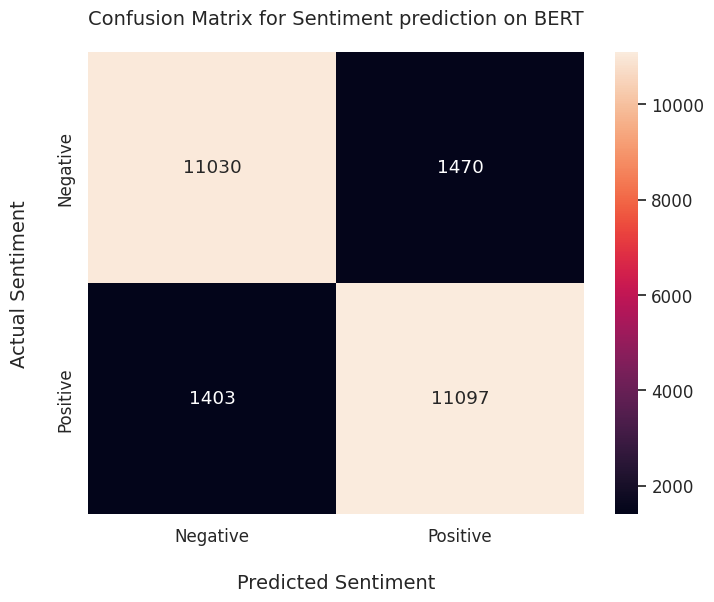

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,6), dpi=100)
sns.set(font_scale = 1.1)

ax = sns.heatmap(conf_matrix, annot=True, fmt='d', )

ax.set_xlabel("Predicted Sentiment", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])

ax.set_ylabel("Actual Sentiment", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Negative', 'Positive'])

ax.set_title("Confusion Matrix for Sentiment prediction on BERT", fontsize=14, pad=20)

plt.show()